In [1]:
import matplotlib
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

def plot_training(trainer) -> None:
    plt.figure(0, figsize=(20, 8))
    plt.clf()
    plt.title(f'Episode {trainer.episode_n}')

    if trainer.batch_n:
        plt.delaxes()
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_xlabel('Batch Number')
        ax1.set_ylabel('Loss')
        ax1.scatter(tuple(range(trainer.batch_n)), trainer.losses)

        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Total Reward')
        ax2.scatter(tuple(range(trainer.episode_n + 1)), trainer.episode_rewards)

        plt.tight_layout()

    else:
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.scatter(tuple(range(trainer.episode_n + 1)), trainer.episode_rewards)

    if is_ipython:                                                              
        display.display(plt.gcf())
        display.clear_output(wait=True)

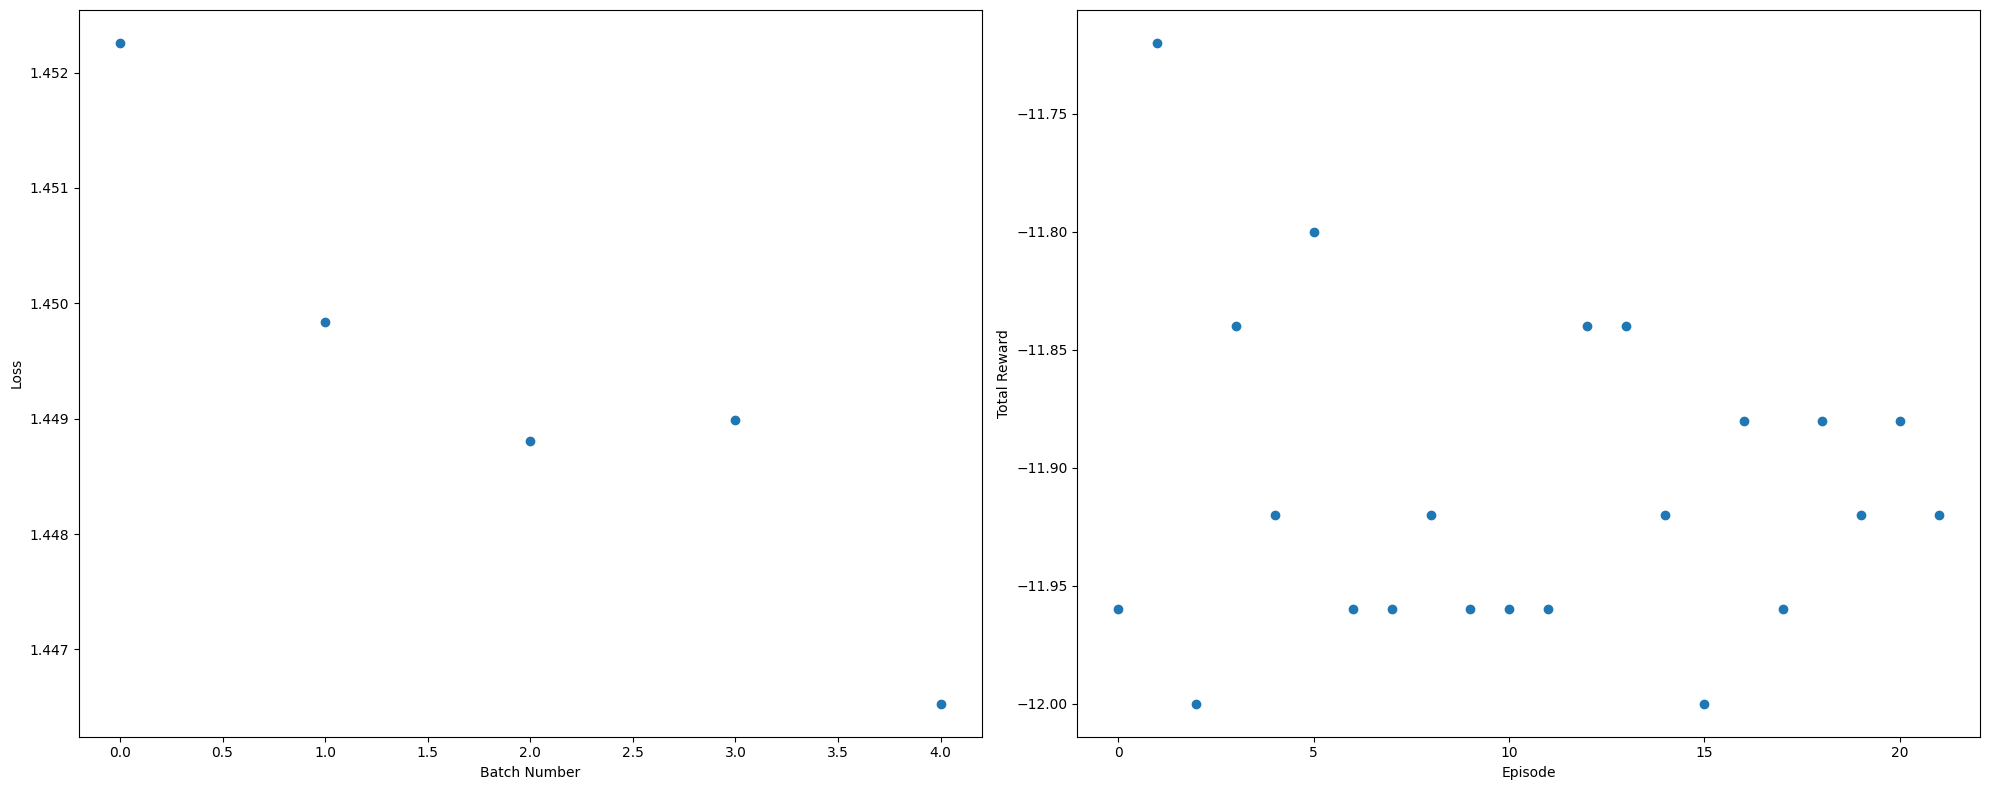

In [ ]:
import torch
import torch.optim as optim

import os
import sys
parent_dir = '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(parent_dir)

from wordle import Wordle
from wordle import load_vocab

from wordle_net import Checkpointer
from wordle_net import EarlyStopper
from wordle_net import DQN
from wordle_net import DQNTrainer
from wordle_net import ConvPoolConfig
from wordle_net import FCConfig


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TARGET_LEN = 5
ALL_WORDS = load_vocab(f'../corncob_caps_5.txt')
N_ACTIONS = len(ALL_WORDS)

conv_pool_configs = [
    # ConvPoolConfig(conv_out, conv_kernel_size, pool_kernel_size, pool_stride, dropout)
    ConvPoolConfig(DQN.channels_in, 1,           0, 0,                          0.05),
    ConvPoolConfig(DQN.channels_in * 4, 3,       (1, 3), (0, 1),                0.1),
    ConvPoolConfig(DQN.channels_in * 8, 3,       (1, 2), (0, 1),                0.1)
]
fcin = DQN.get_fcin(
    DQN.get_input_size(TARGET_LEN),
    DQN.make_conv_pool_layers(conv_pool_configs)
)
fc_configs = [
    FCConfig(2 ** 12, 0.5),
    FCConfig(N_ACTIONS, 0.)
]

wordle_net = DQN(TARGET_LEN, ALL_WORDS, conv_pool_configs, fc_configs).to(device)

lr = 1e-5
optimizer = optim.AdamW(wordle_net.parameters(), lr=lr, amsgrad=True)
checkpointer = Checkpointer('../checkpoints', 'model_5c.pt', 'optim_5c.pt')
checkpointer.checkpoint(None, wordle_net, optimizer)
stopper = EarlyStopper(
    min_delta=0.0,
    patience=50,
    start_episode=200
)


def reward(state, status, guess_n, target_len) -> float:
    turn_value = 10.
    reward = -turn_value
    reward += sum(
        1./target_len for hint in state[Wordle.hint_channel, guess_n - 1]
        if hint == Wordle.correct
    )
    reward += Wordle.max_attempts * turn_value * int(status == Wordle.won)
    return reward / target_len

trainer = DQNTrainer(
    reward_func=reward,
    optimizer=optimizer,
    checkpointer=checkpointer,
    stopper=stopper,
    device=device,
    n_episodes=300,
)
wordle_net.train_model(trainer, plot_training=plot_training)
    
plt.ioff();

In [ ]:
wordle_net.eval()

game = Wordle(ALL_WORDS)
print(f'{game.target = }')
while game.check_state() == Wordle.ongoing:
    state = torch.tensor(game.state, dtype=torch.uint8, device=device).unsqueeze(0)
    with torch.no_grad():
        action = wordle_net(state).max(1).indices.view(1, 1)
        guess = ALL_WORDS[action]
    print(f'guessing: {guess}')
    game.guess(guess)
    print(game.state)

In [ ]:
"""
npn = DQN(n_actions)
npn.load_state_dict(torch.load('../checkpoints/model.pt'))
"""